# Pre-process raw data into .npz files

In [1]:
from __future__ import division, print_function # Makes division and printing work like python 3 (we're using 2)
import os
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from scipy.spatial import distance
import csv
%matplotlib inline
from numpy import arange, sin, pi, cos
from scipy.fftpack import fft, dct

### Load pre-trained GloVe data (Twitter 100d) into a dictionary

In [2]:
twitter_words = np.loadtxt("GloVeTwitter27B/100d.txt", usecols=range(0, 1), dtype = "string")

twitter_vectors = np.loadtxt("GloVeTwitter27B/100d.txt", usecols=range(1, 101), dtype = "float")

twitter_table = {}
for i in range(twitter_words.size):
    twitter_table[twitter_words[i]] = twitter_vectors[i]

In [3]:
vector_dim = twitter_vectors.shape[1]
vector_dim

100

### Load pre-trained GloVe data (Wiki&Gigaword 100d) into a dictionary

In [ ]:
# wiki_words = np.loadtxt("GloVeWiki6B/100d.txt", usecols=range(0, 1), dtype = "string")

# wiki_vectors = np.loadtxt("GloVeWiki6B/100d.txt", converters = {(1,101): lambda s: float(s.strip() or 0)}, 
#                           usecols=range(1, 101), dtype = "float")

# wiki_table = {}
# print(wiki_words.size)
# for i in range(wiki_words.size):
#     wiki_table[wiki_words[i]] = wiki_vectors[i]

### Load recorded raw word transcriptions + head motion data

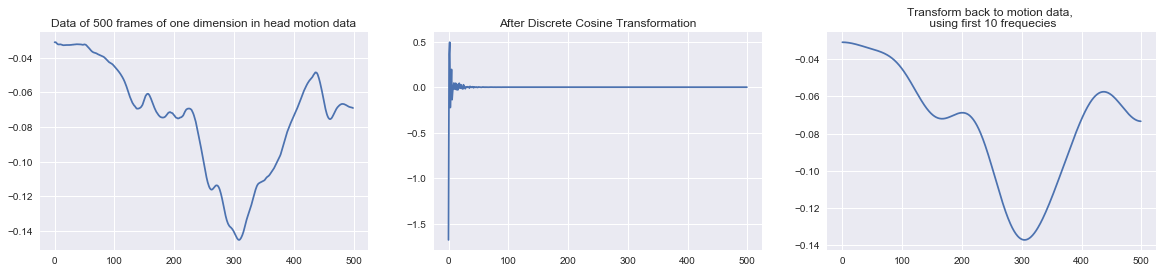

In [56]:
i = 500
col = 1

m = motion_data[0:i, col:col+1].reshape(i)
tm = dct(m, norm="ortho")

extracted = np.zeros(i)
extracted[0:10] = tm[0:10]
rev = dct(extracted, 3, norm="ortho")

f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize = (20, 4))
ax1.plot(m)
ax2.plot(tm)
ax3.plot(rev)
ax1.set_title("Data of {0} frames of one dimension in head motion data".format(i))
ax2.set_title("After Discrete Cosine Transformation")
ax3.set_title("Transform back to motion data, \n using first 10 frequecies")
plt.show()

In [176]:
def cdt_motion(motion_data, start_time, end_time, duration):
    output = np.zeros((motion_data.shape[1],10))

    for i in range(motion_data.shape[1]):
        # In case the availble length of motion is not as long as duration, e.g. at the end of a motion file
        temp = motion_data[start_time:end_time, i:i+1]
        temp = temp.reshape(len(temp))
        motion = np.zeros(duration)
        motion[0:len(temp)] = temp
        output[i] = dct(motion, norm="ortho")[:10]
    return output.reshape(60)

In [177]:
def pre_process_data(inputs, targets, words, motion_data, time_intervals, check_table, duration):

    for index, word in enumerate(words):
        start_time = time_intervals[index][0]
        end_time = start_time + duration
        
        word_split = word.split('\'')
        
        if len(word_split) <= 1:
            transed_motion = cdt_motion(motion_data, start_time, end_time, duration)
            targets.append(transed_motion)
            
            if word in check_table:
                inputs.append(check_table[word])
            else:
                inputs.append(np.zeros(vector_dim))
        else:   
            word_split[1] = '\'' + word_split[1]
            mid = int((start_time + end_time) / 2)
            
            transed_motion_1 = cdt_motion(motion_data, start_time, start_time+duration, duration)
            targets.append(transed_motion_1)            
            
            transed_motion_2 = cdt_motion(motion_data, mid, mid+duration, duration)
            targets.append(transed_motion_2)            
            
            if word_split[0] in check_table:
                inputs.append(check_table[word_split[0]])
                if word_split[1] in check_table:
                    inputs.append(check_table[word_split[1]])
                else:
                    inputs.append(np.zeros(vector_dim))
            else:
                inputs.append(np.zeros(vector_dim))
                if word_split[1] in check_table:
                    inputs.append(check_table[word_split[1]])
                else:
                    inputs.append(np.zeros(vector_dim))

In [188]:
# Load Extrovert/Introvert 1-6 into test data
# Load Extrovert/Introvert 7-12 into validation data
# Load Extrovert/Introvert 13-46 into train data

inputs = []
targets = []

for i in range(7, 13):
    motion_data = np.loadtxt("ExtrovertRawData/Motion/{0}.rov".format(i), skiprows=17, usecols=range(0, 6))
    time_intervals = np.loadtxt("ExtrovertRawData/Words/{0}".format(i), usecols=range(4, 6), dtype="int")
    words = np.loadtxt("ExtrovertRawData/Words/{0}".format(i), usecols=range(3, 4), dtype="string")

    for index, word in enumerate(words):
        words[index] = word.lower()
        
    pre_process_data(inputs, targets, words, motion_data, time_intervals, twitter_table, 30)

In [189]:
inputs_array = np.array(inputs)
targets_array = np.array(targets)

In [190]:
print(inputs_array.shape)
print(targets_array.shape)

(3912, 100)
(3912, 60)


In [191]:
np.savez('data/Baseline_DCT/validation_extro.npz', inputs=inputs_array, targets=targets_array)

In [192]:
trail_d = np.load('data/Baseline_DCT/validation_extro.npz')
print(trail_d['targets'].shape)
print(trail_d['inputs'].shape)

(3912, 60)
(3912, 100)


In [193]:
# Make 1-6 individual test data
for i in range(1, 7):
    inputs = []
    targets = []
    
    motion_data = np.loadtxt("ExtrovertRawData/Motion/{0}.rov".format(i), skiprows=17, usecols=range(0, 6))
    time_intervals = np.loadtxt("ExtrovertRawData/Words/{0}".format(i), usecols=range(4, 6), dtype="int")
    words = np.loadtxt("ExtrovertRawData/Words/{0}".format(i), usecols=range(3, 4), dtype="string")

    print("Test case {0}: input dim: {1}, target dim: {2}".format(i, time_intervals.shape, motion_data.shape))
    
    for index, word in enumerate(words):
        words[index] = word.lower()
        
    pre_process_data(inputs, targets, words, motion_data, time_intervals, twitter_table, 30)
    inputs_array = np.array(inputs)
    targets_array = np.array(targets)
    np.savez('data/Baseline_DCT/test{0}_extro.npz'.format(i), inputs=inputs_array, targets=targets_array)
    trail_d = np.load('data/Baseline_DCT/test{0}_extro.npz'.format(i))
    print("Input dim: ", trail_d['inputs'].shape, "Target dim: ", trail_d['targets'].shape)

Test case 1: input dim: (562, 2), target dim: (31467, 6)
Input dim:  (597, 100) Target dim:  (597, 60)
Test case 2: input dim: (719, 2), target dim: (31983, 6)
Input dim:  (768, 100) Target dim:  (768, 60)
Test case 3: input dim: (607, 2), target dim: (35331, 6)
Input dim:  (655, 100) Target dim:  (655, 60)
Test case 4: input dim: (806, 2), target dim: (30155, 6)
Input dim:  (861, 100) Target dim:  (861, 60)
Test case 5: input dim: (578, 2), target dim: (31798, 6)
Input dim:  (624, 100) Target dim:  (624, 60)
Test case 6: input dim: (938, 2), target dim: (34518, 6)
Input dim:  (1037, 100) Target dim:  (1037, 60)


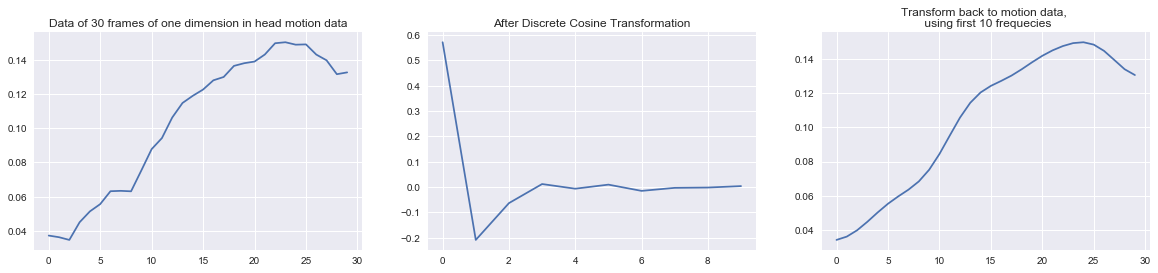

In [182]:
# Test cell

i = 30
col = 0

motion_data = np.loadtxt("ExtrovertRawData/Motion/13.rov", skiprows=17, usecols=range(0, 6))
time_intervals = np.loadtxt("ExtrovertRawData/Words/13", usecols=range(4, 6), dtype="int")

st = time_intervals[0,0]

m = motion_data[st:st+30, col:col+1].reshape(i)
tm = dct(m, norm="ortho")

doesitwork = targets_array[0,0:10]

extracted = np.zeros(i)
extracted[0:10] = doesitwork
rev = dct(extracted, 3, norm="ortho")

f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize = (20, 4))
ax1.plot(m)
ax2.plot(doesitwork)
ax3.plot(rev)
ax1.set_title("Data of {0} frames of one dimension in head motion data".format(i))
ax2.set_title("After Discrete Cosine Transformation")
ax3.set_title("Transform back to motion data, \n using first 10 frequecies")
plt.show()